# FOOD RECIPE RECOMMENDATION ENGINE

## Part 2c: Model-Based Collaborative Filtering

In [1]:
import pandas as pd
from surprise.model_selection import cross_validate, train_test_split
from surprise import Dataset, Reader
from surprise import accuracy
from src.model_based import *

### Load data

In [2]:
# Load recipes
recipes = pd.read_feather("./data/recipes.feather")

# Load interactions
interactions = pd.read_feather("./data/interactions.feather")

# Map new user and recipe IDs for later use
recipes, interactions = map_dfs(recipes, interactions)

In [3]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(interactions[["user_id", "recipe_id", "rating"]], reader=reader)

### Find best model

We will choose `SVD()`, `NMF()`, `NormalPredictor()`, and `BaselineOnly()` as candidate models and use the one with the lowest test RMSE.

In [4]:
algorithms = [SVD(), NMF(), NormalPredictor(), BaselineOnly()]
get_benchmark(data, algorithms)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.683965,5.814223,2.830109
SVD,0.687877,45.645343,3.686463
NMF,0.862362,88.629795,3.283360
NormalPredictor,0.909657,1.643114,3.257455


The `BaselineOnly()` model gives us the best test RMSE. We will use it to build our final model.

### Build model

In [5]:
print("Using ALS")
bsl_options = {"method": "als",
               "n_epochs": 5,
               "reg_u": 12,
               "reg_i": 5}
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=["RMSE"], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.68373213, 0.68268261, 0.68541837]),
 'fit_time': (2.939826011657715, 3.5368618965148926, 3.351400136947632),
 'test_time': (3.5641400814056396, 3.306881904602051, 3.550987958908081)}

### Make predictions

In [6]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.6857


0.6857315080508238

### Evaulate model

In [7]:
# Predictions for all users
df_predictions = make_predictions_df(predictions, trainset)
best_predictions = df_predictions.sort_values(by="err")[:10]
worst_predictions = df_predictions.sort_values(by="err")[-10:]

In [8]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
21887,48138,6532.0,5.0,5.0,{'was_impossible': False},125,128,0.0
36295,135817,224778.0,5.0,5.0,{'was_impossible': False},38,31,0.0
223286,4189,18561.0,5.0,5.0,{'was_impossible': False},103,2,0.0
104624,18955,58142.0,5.0,5.0,{'was_impossible': False},956,24,0.0
188189,562,179457.0,5.0,5.0,{'was_impossible': False},1108,8,0.0
223267,59962,37087.0,5.0,5.0,{'was_impossible': False},14,5,0.0
104627,28386,162296.0,5.0,5.0,{'was_impossible': False},590,11,0.0
104655,72610,172882.0,5.0,5.0,{'was_impossible': False},64,17,0.0
104681,11934,84057.0,5.0,5.0,{'was_impossible': False},436,67,0.0
223232,6498,16795.0,5.0,5.0,{'was_impossible': False},115,294,0.0


In [9]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
51332,18599,98786.0,1.0,4.969185,{'was_impossible': False},950,10,3.969185
188452,45683,46226.0,1.0,4.971837,{'was_impossible': False},36,63,3.971837
260837,9672,101522.0,1.0,4.984830,{'was_impossible': False},24,5,3.984830
64815,156615,198546.0,1.0,4.990164,{'was_impossible': False},0,8,3.990164
265083,12545,27703.0,1.0,4.994936,{'was_impossible': False},16,11,3.994936
182299,9919,43824.0,1.0,4.995110,{'was_impossible': False},14,14,3.995110
22371,67404,59578.0,1.0,4.998880,{'was_impossible': False},78,151,3.998880
132470,35180,158195.0,1.0,5.000000,{'was_impossible': False},11,18,4.000000
199915,30811,18229.0,1.0,5.000000,{'was_impossible': False},89,251,4.000000
113391,3213,53183.0,1.0,5.000000,{'was_impossible': False},384,23,4.000000


Upon inspection of the worst predictions, a general trend we see is that the users for these predictions have given outlying ratings for recipes that tend to lean in a different direction. We also see that for our best predictions, the recipes tend to have a consistent rating. You can uncomment the code below to try it yourself.

In [10]:
# inspect_results(interactions, recipe_id=24068, user_id=63861)

### Determine optimal number of recipes

To determine the optimal number of recipes to recommend to users, we first need to calculate the precision and recall for each user. We set the maximum possible number of recommendations at 10 and a threshold of 3.5. From the precision and recall curves, recall seems to dramatically decline if we go below $k=3$, at which point we also do not see significant increase in precision. Therefore, we will recommend 3 recipes to each user.

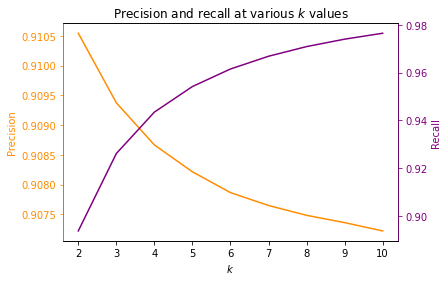

In [11]:
pr_ks = get_pr_ks(predictions)
plot_prs(pr_ks)

### Make recommendations

We start by providing a `user_id` and a few `recipe_id`s the user has rated. We will use these rating as ground truth labels and help us predict which other recipes the user would rate highly. Try it below yourself!

In [12]:
uid = 4470 # User ID
iids = [23739, 24549, 8103] # Recipe IDs

recommend(uid, iids, recipes, algo)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
47402,Chilean Salsa,36551,25,37779,2003-06-05,"[lactose, 30-minutes-or-less, time-to-make, co...","[374.3, 43.0, 62.0, 73.0, 11.0, 18.0, 9.0]",4,"[in a mortar , crush the garlic , chile pepper...","after trying this salsa, it is hard to go back...","[garlic cloves, green serrano chilies, sea sal...",9
106461,Homemade Condensed Cream Of Chicken Or Mushroo...,198546,20,314785,2009-11-03,"[30-minutes-or-less, time-to-make, course, pre...","[106.7, 4.0, 0.0, 13.0, 9.0, 7.0, 5.0]",10,"[in medium-sized saucepan , boil chicken broth...",you have these ingredients already. so save y...,"[chicken broth, poultry, onion powder, garlic ...",10
156974,Pecan Crusted Ice Cream Pie With Caramel Sauce,35756,45,29063,2003-05-20,"[60-minutes-or-less, time-to-make, course, mai...","[451.6, 37.0, 188.0, 5.0, 10.0, 61.0, 19.0]",8,"[preheat oven to 400 degrees f, to make crust ...",found this in our paper... haven't tried it ye...,"[egg white, sugar, pecans, coffee ice cream, f...",11


### Conclusion

With model-based recommenders, we try to compute latent factors that would give rise to the user-item matrix, then use these factors to predict the rating a user would give to a recipe that they have not previously rated. Similar to the memory-based algorithm, the model-based algorithm also works with ratings, and we need to take data sparsity into account before we choose a model. Out of all methods we explore in this project, the model-based algorithm is the least interpretable. However, it is able to recommend a diverse range of recipes to users without using a huge amount of memory.